# Main

In [40]:
'''
Dependencies
'''
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sparse
import copy
import time
import warnings 
from scipy import integrate
import seaborn as sns
warnings.simplefilter('ignore')
from sklearn.decomposition import PCA
import scipy.io as sio
import os
from tqdm.auto import tqdm
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

sns.set_style('white')
# to change default color cycle
color_scheme = ['#616F85', '#C2BAA3', '#F5E6CE', '#DD9D7C', '#C9445F']
color_scheme_bluered = ['#074B6A', '#0A82A4', '#C0E995', '#F3EE7E', '#E64248']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_scheme_bluered)

import pyaldata as pld # using functions from PyalData
import tools # matlab2python functions

## 0.  Load data and convert to pandas dataframe

The original data are in the form of `.mat` files. Pandas makes it very easy to work with the data. The entire dataset is a set of sessions $S$ of $T$ trials and each trial has $F$ features. The dataset is of the form
\begin{align}
    S \times T \times F
\end{align}

We will do the analysis for one session to begin with, yielding a $T \times F$ matrix.

In [45]:
'''
Insert path and filename 
'''
path = '/Users/Daphne/Data/'  
fname = 'Chewie_CO_VR_2016-10-06.mat' 
df = pld.mat2dataframe(path+fname, shift_idx_fields=True)

In [46]:
df.shape # T x F

(774, 24)

In [47]:
df.head()

,monkey,date,task,target_direction,trial_id,result,bin_size,perturbation,perturbation_info,epoch,...,idx_peak_speed,idx_trial_end,pos,vel,acc,force,M1_spikes,M1_unit_guide,PMd_spikes,PMd_unit_guide
0,Chewie,10-06-2016,CO,-2.356194,1,R,0.01,VR,-0.52,BL,...,363,436,"[[-5.399950889827338, -25.11058978269873], [-5...","[[4.615264447089089, -3.6781866137904946], [4....","[[34.913180411358354, -17.92603186704403], [13...","[[0.3854857746577438, -0.18448026169727955], [...","[[0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,...","[[5, 1], [5, 2], [5, 3], [5, 4], [9, 1], [9, 2...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [1, 2], [2, 1], [2, 2], [3, 1], [3, 2..."
1,Chewie,10-06-2016,CO,1.570796,2,R,0.01,VR,-0.52,BL,...,356,447,"[[-5.194667657852522, -35.190944353130526], [-...","[[2.3921738136280783, 2.833707639241631], [2.7...","[[31.99226756476989, 80.42711312188004], [34.1...","[[0.1778157378731141, 0.12542049016429982], [0...","[[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,...","[[5, 1], [5, 2], [5, 3], [5, 4], [9, 1], [9, 2...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [1, 2], [2, 1], [2, 2], [3, 1], [3, 2..."
2,Chewie,10-06-2016,CO,0.785398,3,R,0.01,VR,-0.52,BL,...,414,483,"[[0.35267826312911055, -22.923278550949004], [...","[[0.5017102009485903, -3.146994710197926], [0....","[[-7.180978950112355, -35.21789901845524], [3....","[[0.2833417683274762, -0.1285513884878812], [0...","[[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...","[[5, 1], [5, 2], [5, 3], [5, 4], [9, 1], [9, 2...","[[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [1, 2], [2, 1], [2, 2], [3, 1], [3, 2..."
3,Chewie,10-06-2016,CO,3.141593,4,R,0.01,VR,-0.52,BL,...,397,458,"[[5.072834875801728, -24.89410841851521], [5.0...","[[-1.3275097541588876, -3.5308863978243985], [...","[[-6.932033881542791, 0.17982626642873387], [-...","[[0.08675043530985374, 0.03658922221440793], [...","[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[5, 1], [5, 2], [5, 3], [5, 4], [9, 1], [9, 2...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [1, 2], [2, 1], [2, 2], [3, 1], [3, 2..."
4,Chewie,10-06-2016,CO,-1.570796,5,R,0.01,VR,-0.52,BL,...,301,362,"[[-8.194254800472459, -30.26359832666607], [-8...","[[1.8501123719868446, 0.8394848146862552], [2....","[[48.123169514922175, -9.081942493745938], [58...","[[0.2054977133197953, -0.12485484173352068], [...","[[0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,...","[[5, 1], [5, 2], [5, 3], [5, 4], [9, 1], [9, 2...","[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [1, 2], [2, 1], [2, 2], [3, 1], [3, 2..."


In [48]:
df.columns

Index(['monkey', 'date', 'task', 'target_direction', 'trial_id', 'result',
       'bin_size', 'perturbation', 'perturbation_info', 'epoch',
       'idx_trial_start', 'idx_target_on', 'idx_go_cue', 'idx_movement_on',
       'idx_peak_speed', 'idx_trial_end', 'pos', 'vel', 'acc', 'force',
       'M1_spikes', 'M1_unit_guide', 'PMd_spikes', 'PMd_unit_guide'],
      dtype='object')

In [53]:
df.monkey.unique()

array(['Chewie'], dtype=object)

## 1. Preprocess 

I am following the parameters and workflow from `compare_weights_spatially.m`

### 1.1 Combine time bins

Combine time bins into larger ones, here 

In [49]:
td = pld.combine_time_bins(df, n_bins=3)

In [7]:
# print(f'before \n {df.head().bin_size} \n')
# print(f'after combining time bins \n {td.head().bin_size}')

### 1.2 Remove low firing neurons

In [8]:
df.M1_spikes[0]

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 0, 0]], dtype=uint8)

In [9]:
td = pld.remove_low_firing_neurons(td, signal='M1_spikes', threshold=5)
td = pld.remove_low_firing_neurons(td, signal='PMd_spikes', threshold=5)

print(f'original M1 spikes: {df.M1_spikes[0].shape}')
print(f'after removing low firing neurons: {td.M1_spikes[0].shape} \n')

print(f'original PMd spikes: {df.PMd_spikes[0].shape}')
print(f'after removing low firing neurons: {td.PMd_spikes[0].shape}')

original M1 spikes: (447, 63)
after removing low firing neurons: (149, 44) 

original PMd spikes: (447, 192)
after removing low firing neurons: (149, 99)


### 1.3 Transform signals

In [10]:
td = pld.transform_signal(td, signal='M1_spikes',  transformations='sqrt')
td = pld.transform_signal(td, signal='PMd_spikes', transformations='sqrt')

print(td.M1_spikes[0]) # trials x neurons

[[1.         1.         1.         ... 0.         0.         1.        ]
 [0.         1.         0.         ... 0.         1.         0.        ]
 [1.         1.         1.41421356 ... 0.         1.         0.        ]
 ...
 [1.         0.         0.         ... 0.         0.         0.        ]
 [1.         1.         1.41421356 ... 0.         1.         1.        ]
 [0.         1.         0.         ... 0.         1.         0.        ]]


### 1.4 Merge signals from multiple brain areas

Here we add a column `'both_spikes'` to that we can perform PCA on all the neurons

In [11]:
td = pld.merge_signals(td, ['M1_spikes', 'PMd_spikes'], 'both_spikes')

print(f'Merging M1 and PMd gives {td.M1_spikes[0].shape[1]} + {td.PMd_spikes[0].shape[1]} = {td.both_spikes[0].shape[1]} neurons')

Merging M1 and PMd gives 44 + 99 = 143 neurons


In [12]:
td['both_spikes']

0      [[1.0, 1.0, 1.0, 1.4142135623730951, 0.0, 0.0,...
1      [[1.0, 1.0, 0.0, 1.0, 1.0, 1.4142135623730951,...
2      [[1.0, 1.0, 1.4142135623730951, 0.0, 0.0, 1.41...
3      [[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4      [[0.0, 0.0, 1.0, 1.4142135623730951, 1.0, 1.0,...
                             ...                        
769    [[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0,...
770    [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
771    [[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.41...
772    [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...
773    [[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0,...
Name: both_spikes, Length: 774, dtype: object

### 1.5 Compute firing rates from spike trains


In [13]:
# works on '_spikes' fields and automatically divides by bin_size
td = pld.add_firing_rates(td, 'smooth')

In [14]:
td.head()

,monkey,date,task,target_direction,trial_id,result,bin_size,perturbation,perturbation_info,epoch,...,acc,force,M1_spikes,M1_unit_guide,PMd_spikes,PMd_unit_guide,both_spikes,M1_rates,PMd_rates,both_rates
0,Chewie,10-06-2016,CO,-2.356194,1,R,0.03,VR,-0.52,BL,...,"[[25.292273710326047, 23.948816622289783], [26...","[[0.3854857746577438, -0.18448026169727955], [...","[[1.0, 1.0, 1.0, 1.4142135623730951, 0.0, 0.0,...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[1.0, 1.0, 1.0, 1.4142135623730951, 0.0, 0.0,...","[[10.371933240023875, 15.773752026832693, 12.3...","[[8.902097383481504, 8.635500399091704, 6.2947...","[[10.371933240023875, 15.773752026832693, 12.3..."
1,Chewie,10-06-2016,CO,1.570796,2,R,0.03,VR,-0.52,BL,...,"[[33.67115720999763, 79.08430607100303], [23.7...","[[0.1778157378731141, 0.12542049016429982], [0...","[[1.0, 1.0, 0.0, 1.0, 1.0, 1.4142135623730951,...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.414213562373...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[1.0, 1.0, 0.0, 1.0, 1.0, 1.4142135623730951,...","[[11.264847879857852, 14.03731918590052, 8.031...","[[5.401818786808815, 14.407176539761242, 13.14...","[[11.264847879857852, 14.03731918590052, 8.031..."
2,Chewie,10-06-2016,CO,0.785398,3,R,0.03,VR,-0.52,BL,...,"[[1.6623846773446733, -20.151668914256682], [4...","[[0.2833417683274762, -0.1285513884878812], [0...","[[1.0, 1.0, 1.4142135623730951, 0.0, 0.0, 1.41...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[1.0, 1.4142135623730951, 1.0, 0.0, 0.0, 0.0,...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[1.0, 1.0, 1.4142135623730951, 0.0, 0.0, 1.41...","[[10.371933240023875, 16.66666666666667, 11.84...","[[16.66666666666667, 10.949669788579067, 7.742...","[[10.371933240023875, 16.66666666666667, 11.84..."
3,Chewie,10-06-2016,CO,3.141593,4,R,0.03,VR,-0.52,BL,...,"[[-10.229040288523265, -22.654816986306813], [...","[[0.08675043530985374, 0.03658922221440793], [...","[[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[0.0, 1.0, 0.0, 0.0, 0.0, 1.4142135623730951,...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8929146398339769, 8.635500399091704, 10.26...","[[0.8929146398339769, 7.742585759257727, 5.401...","[[0.8929146398339769, 8.635500399091704, 10.26..."
4,Chewie,10-06-2016,CO,-1.570796,5,R,0.03,VR,-0.52,BL,...,"[[55.86100520057167, -6.586410543949703], [45....","[[0.2054977133197953, -0.12485484173352068], [...","[[0.0, 0.0, 1.0, 1.4142135623730951, 1.0, 1.0,...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[1.0, 1.0, 0.0, 1.4142135623730951, 0.0, 0.0,...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[0.0, 0.0, 1.0, 1.4142135623730951, 1.0, 1.0,...","[[8.031166267574964, 8.924080907408943, 13.144...","[[15.773752026832693, 16.66666666666667, 0.892...","[[8.031166267574964, 8.924080907408943, 13.144..."


In [15]:
td.both_rates

0      [[10.371933240023875, 15.773752026832693, 12.3...
1      [[11.264847879857852, 14.03731918590052, 8.031...
2      [[10.371933240023875, 16.66666666666667, 11.84...
3      [[0.8929146398339769, 8.635500399091704, 10.26...
4      [[8.031166267574964, 8.924080907408943, 13.144...
                             ...                        
769    [[0.8929146398339769, 9.005357752952426, 0.0, ...
770    [[6.294733426642792, 8.924080907408943, 0.8929...
771    [[14.407176539761242, 9.120277654299834, 7.742...
772    [[0.8929146398339769, 10.371933240023875, 0.0,...
773    [[10.371933240023875, 16.66666666666667, 8.635...
Name: both_rates, Length: 774, dtype: object

### 1.6 Select a time interval

Perhaps we want to take spikes from a certain interval (this is optional). 

```Python

if which_period == 'plan':
    idx_start = df['idx_target_on'][0]
    idx_end = df['idx_go_cue'][0]
    
elif which_period == 'move':
    idx_start = df['idx_go_cue'][0]
    idx_end = df['idx_trial_end'][0]

elif which_period == 'all':
    idx_start = df['idx_target_on'][0]
    idx_end = df['idx_trial_end'][0]
```

In [16]:
# examples
plan_td = pld.restrict_to_interval(td, start_point_name='idx_target_on', end_point_name='idx_go_cue', before=0, after=40)

move_td = pld.restrict_to_interval(td, start_point_name='idx_go_cue', end_point_name='idx_trial_end', before=0, after=40)

In [17]:
plan_td.head()

,monkey,date,task,target_direction,trial_id,result,bin_size,perturbation,perturbation_info,epoch,...,acc,force,M1_spikes,M1_unit_guide,PMd_spikes,PMd_unit_guide,both_spikes,M1_rates,PMd_rates,both_rates
0,Chewie,10-06-2016,CO,-2.356194,1,R,0.03,VR,-0.52,BL,...,"[[10.970621675691566, -17.90932121190034], [-1...","[[0.3854857746577438, -0.18448026169727955], [...","[[1.0, 0.0, 0.0, 1.7320508075688772, 0.0, 1.73...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0,...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[1.0, 0.0, 0.0, 1.7320508075688772, 0.0, 1.73...","[[19.90034827894956, 16.307925720776602, 16.95...","[[20.886990305324268, 21.855776722546853, 8.63...","[[19.90034827894956, 16.307925720776602, 16.95..."
1,Chewie,10-06-2016,CO,1.570796,2,R,0.03,VR,-0.52,BL,...,"[[-5.774060193805803, -14.365149464093918], [0...","[[0.1778157378731141, 0.12542049016429982], [0...","[[1.0, 1.4142135623730951, 1.0, 0.0, 0.0, 1.0,...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[1.0, 1.4142135623730951, 1.0, 0.0, 0.0, 1.0,...","[[14.03731918590052, 24.84386514920307, 29.811...","[[12.353959266582722, 30.561414643284294, 7.74...","[[14.03731918590052, 24.84386514920307, 29.811..."
2,Chewie,10-06-2016,CO,0.785398,3,R,0.03,VR,-0.52,BL,...,"[[-14.026090735510317, 19.555698702439965], [-...","[[0.2833417683274762, -0.1285513884878812], [0...","[[1.0, 1.0, 1.4142135623730951, 0.0, 0.0, 0.0,...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[1.0, 1.0, 1.4142135623730951, 0.0, 0.0, 0.0,...","[[18.114518999281604, 25.498363812649266, 25.6...","[[16.666666666666668, 21.606923489144744, 0.0,...","[[18.114518999281604, 25.498363812649266, 25.6..."
3,Chewie,10-06-2016,CO,3.141593,4,R,0.03,VR,-0.52,BL,...,"[[-7.076210661439639, -12.075892021608487], [5...","[[0.08675043530985374, 0.03658922221440793], [...","[[1.0, 1.0, 0.0, 1.0, 0.0, 1.4142135623730951,...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[1.4142135623730951, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[1.0, 1.0, 0.0, 1.0, 0.0, 1.4142135623730951,...","[[29.352769296177907, 30.388807761288398, 13.8...","[[27.904916963562975, 16.66666666666667, 3.522...","[[29.352769296177907, 30.388807761288398, 13.8..."
4,Chewie,10-06-2016,CO,-1.570796,5,R,0.03,VR,-0.52,BL,...,"[[-8.645102876130663, -15.463265695438906], [1...","[[0.2054977133197953, -0.12485484173352068], [...","[[1.0, 0.0, 0.0, 0.0, 0.0, 1.4142135623730951,...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0,...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[1.0, 0.0, 0.0, 0.0, 0.0, 1.4142135623730951,...","[[25.30216706575838, 14.325899694217757, 9.816...","[[30.703985852567193, 25.498363812649266, 14.0...","[[25.30216706575838, 14.325899694217757, 9.816..."


In [18]:
print(f'Total trial length: {td.both_spikes[0].shape}')

print(f'Plan trial length: {plan_td.both_spikes[0].shape}')

print(f'Move trial length: {move_td.both_spikes[0].shape}')

Total trial length: (149, 143)
Plan trial length: (75, 143)
Move trial length: (53, 143)


In [19]:
td.epoch # what is this?

0      BL
1      BL
2      BL
3      BL
4      BL
       ..
769    WO
770    WO
771    WO
772    WO
773    WO
Name: epoch, Length: 774, dtype: object

## 2 Dimensionality reduction

We want to perform dimensionality reduction on different subsets;

- Do PCA on all the data together (both the M1 neurons and the PMd neurons) $\rightarrow$ `'all_spikes'`
- Do PCA on the M1 neurons only $\rightarrow$ `'M1_spikes'`
- Do PCA on the PMd neurons only $\rightarrow$ `'PMd_spikes'`

Now we have the firing rates for all the neurons in the M1 and PMd combined:

In [20]:
print(f'Number of trials: {td.both_rates.shape}')
print(f'Each trial has {td.both_rates[0].shape[0]} observations x {td.both_rates[0].shape[1]} neurons ')

Number of trials: (774,)
Each trial has 149 observations x 143 neurons 


In [21]:
td['both_rates']

0      [[10.371933240023875, 15.773752026832693, 12.3...
1      [[11.264847879857852, 14.03731918590052, 8.031...
2      [[10.371933240023875, 16.66666666666667, 11.84...
3      [[0.8929146398339769, 8.635500399091704, 10.26...
4      [[8.031166267574964, 8.924080907408943, 13.144...
                             ...                        
769    [[0.8929146398339769, 9.005357752952426, 0.0, ...
770    [[6.294733426642792, 8.924080907408943, 0.8929...
771    [[14.407176539761242, 9.120277654299834, 7.742...
772    [[0.8929146398339769, 10.371933240023875, 0.0,...
773    [[10.371933240023875, 16.66666666666667, 8.635...
Name: both_rates, Length: 774, dtype: object

In [22]:
# concatenate the rates from different trials in time
all_rates = np.concatenate(td['both_rates'].values, axis=0)
#M1_rates = np.concatenate(td['both_rates'].values, axis=0)

print(all_rates.shape) # observations x neurons
print()
print(all_rates)

(100575, 143)

[[10.37193324 15.77375203 12.35395927 ...  0.89291464  7.74258576
   2.62934748]
 [14.03731919 21.77990495 18.01125863 ...  2.62934748  7.74258576
   6.29473343]
 [16.66666667 24.40925243 22.646222   ...  5.40181879  5.40181879
  10.37193324]
 ...
 [ 0.         16.66666667 15.77375203 ... 13.14440455  5.40181879
  20.64060611]
 [ 0.         14.03731919 14.03731919 ... 15.48517152  7.74258576
  17.75577805]
 [ 0.         10.37193324 10.37193324 ... 13.14440455  7.74258576
  14.40717654]]


In [23]:
'''
Principal Component Analysis
'''

dims = 30
model = PCA(dims)
model.fit(all_rates)

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [24]:
model.singular_values_

array([9816.07306226, 7966.50981902, 7137.56953385, 5807.76126788,
       4947.23370345, 4828.00675611, 4369.19099826, 4133.90862314,
       3961.79651118, 3878.84801488, 3792.69805092, 3674.42273209,
       3512.34449691, 3417.94792127, 3324.76517139, 3295.69718779,
       3155.22351989, 3127.71590043, 3107.66696883, 3061.92569969,
       2926.07008415, 2917.82367283, 2818.00691557, 2749.48958817,
       2706.26463877, 2691.49425707, 2613.80881828, 2583.32577271,
       2568.049409  , 2503.46625248])

In [25]:
print(model.explained_variance_ratio_)

[0.09973066 0.0656885  0.05272952 0.03491167 0.0253325  0.0241262
 0.01975856 0.01768784 0.01624566 0.01557251 0.01488846 0.01397434
 0.01276872 0.01209161 0.01144129 0.01124211 0.01030418 0.0101253
 0.0099959  0.00970381 0.00886181 0.00881193 0.00821935 0.00782451
 0.00758043 0.00749791 0.00707132 0.00690735 0.0068259  0.00648689]


## PCA fit transform

In [26]:
# PCA
pca = PCA()
df_pca = pca.fit_transform(all_rates)

# Store as dataframe and print
df_pca = pd.DataFrame(df_pca)
print(df_pca.shape)  
df_pca.round(2).head()

(100575, 143)


,0,1,2,3,4,5,6,7,8,9,...,133,134,135,136,137,138,139,140,141,142
0,30.84,-33.89,-24.73,-13.89,-12.99,8.61,2.38,-14.62,8.87,11.57,...,-1.12,-0.53,4.91,1.69,-4.46,-2.08,1.83,3.10,-1.13,0.40
1,26.55,-32.16,-3.29,-9.55,-12.24,8.82,-11.29,-9.25,2.13,13.52,...,-0.68,-0.72,5.90,1.29,-4.16,-2.56,2.03,4.37,-1.27,2.10
2,18.85,-30.99,11.38,-8.93,-4.92,10.87,-20.05,-6.76,-4.21,12.23,...,0.02,-1.15,7.02,-0.26,-4.72,-1.90,1.00,5.97,-0.24,3.73
3,8.69,-28.26,18.75,-11.76,6.09,13.66,-24.64,-6.87,-10.82,8.06,...,0.35,-1.95,8.69,-2.53,-7.37,0.33,-1.00,8.06,1.72,4.12
4,0.34,-23.36,22.72,-15.22,14.88,16.35,-26.60,-6.87,-18.05,3.34,...,-0.20,-3.81,10.80,-4.01,-10.65,2.70,-2.20,8.92,3.96,3.48


In [27]:
# principal component weights 
pca_loadings = pd.DataFrame(pca.components_)
pca_loadings.head() # each row contains the weigths or loadings of one PC

,0,1,2,3,4,5,6,7,8,9,...,133,134,135,136,137,138,139,140,141,142
0,-0.092579,-0.049763,-0.098847,0.068122,0.030066,0.126294,-0.116442,-0.001172,0.052950,0.074804,...,-0.025893,-0.111930,-0.026005,-0.015751,0.077641,-0.183244,0.007308,-0.003380,0.246121,-0.079911
1,-0.115257,-0.167899,-0.177552,-0.187255,-0.091580,0.037434,-0.012773,-0.008880,-0.059865,0.018422,...,0.006887,0.004827,0.025076,-0.008623,0.072452,0.128328,-0.099575,0.011951,0.183839,-0.008262
2,0.182504,0.201026,0.139522,0.169846,0.190105,0.131181,-0.008674,0.013614,0.117575,0.081361,...,0.029894,-0.012017,0.027075,0.003329,0.069836,0.033092,0.120333,0.042552,0.162085,-0.077813
3,-0.019358,-0.090796,0.092808,0.204580,0.025638,0.276798,0.005954,0.108890,-0.075985,0.010896,...,0.049525,0.002130,-0.003676,0.008950,0.040731,0.146902,-0.035910,0.015239,-0.104200,0.161135
4,-0.032314,-0.112025,-0.068264,-0.053151,0.132713,0.061960,0.030345,0.082347,0.030847,-0.052165,...,0.050329,-0.032277,0.003006,0.029479,0.036516,-0.002644,-0.008664,0.041312,-0.010845,0.027815


PC1 contributed 10%, PC2 contributed 7% and so on.

In [28]:
pca.explained_variance_ratio_.round(2)

array([0.1 , 0.07, 0.05, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [29]:
len(pca.explained_variance_ratio_) # for each of the 143 neurons

143

In [30]:
binz = np.arange(0, 0.5, 0.005)

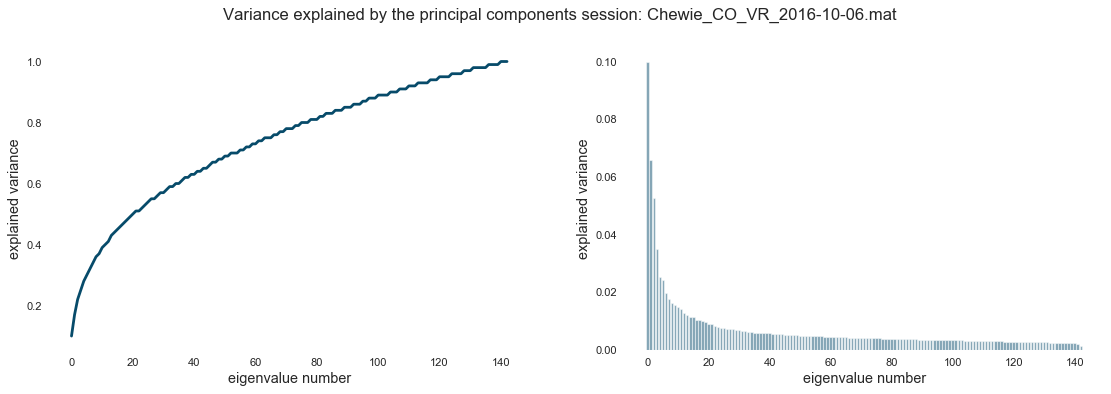

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5), dpi=80)
fig.suptitle(f'Variance explained by the principal components session: {fname}', fontsize=15)
variance_exp_cumsum = pca.explained_variance_ratio_.cumsum().round(2)
ax1.plot(variance_exp_cumsum, lw=2.5)
ax1.set_xlabel('eigenvalue number', fontsize=13)
ax1.set_ylabel('explained variance', fontsize=13);

ax2.bar(range(0, len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, alpha=0.5, align='center')
ax2.set_xlabel('eigenvalue number', fontsize=13)
ax2.set_ylabel('explained variance', fontsize=13)
sns.despine(left=True, bottom=True);

### A. Investigating the principal component weights

> Motivation

It is standard to perform dimensionality reduction on the data to find a lower dimensional Manifold. Not much attention is payed to the lower principal components, while this could be interesting as well. Let's say we have the following decomposition of the spike trains
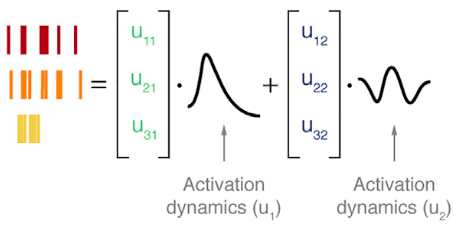
where $\mathbf{u}_1 = [u_{11}, u_{21}, u_{31}]$ and $\mathbf{u}_2 = [u_{12}, u_{22}, u_{32}]$ are the weight vectors. These weight vectors in themselves can also be informative because they tell us what the loading of each of the dimensions - for each neuron - is.

We would like to understand if there is a relationship (correlation) between the weight vectors and the spatial location in the brain. 